In [1]:
try:
    import mesa
except:
    !pip install mesa --quiet
import mesa
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

# Helper functions

In [2]:
# Based on book "Growing artificial soscieties" 
# p.90 - p. 110 for detailed information on trading and welfare calculation


def get_distance(pos_1, pos_2):
    """
    Calculate the Euclidean distance between two positions
    used in trade.move()
    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    """
    helper function for model datacollector for trade price
    collapse agent price list into on list
    """
    return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
    """
    find the geometic mean of a list of prices
    """
    return np.exp(np.log(list_of_prices).mean())

# Resource classes

In [3]:
class Sugar(mesa.Agent):
    """
    Sugar:
    -contains an amount of sugar
    -has max capacity
    -grows every turn
    """
    
    def __init__(self, unique_id, model, pos, max_sugar):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_sugar
        self.max_sugar = max_sugar
        
    def step(self):
        """
        Sugar every step:
        -adds unit of sugar each step untill max amount
        """
        
        self.amount = min([self.max_sugar, self.amount+1])
        

class Spice(mesa.Agent):
    """
    Spice:
    -contains an amount of spice
    -has max capacity
    -grows every turn
    """
    
    def __init__(self, unique_id, model, pos, max_spice):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_spice
        self.max_spice = max_spice
        
    def step(self):
        """
        Spice every step:
        -adds unit of spice each step untill max amount
        """
        
        self.amount = min([self.max_spice, self.amount+1])

# Trader class

In [4]:
class Trader(mesa.Agent):
    """
    Trader:
    -has a metabolism of sugar and spice
    -harvest and trade sugar and spice to survive
    """
    
    def __init__(self, unique_id, model, pos, moore=False, sugar=0,
                 spice=0, metabolism_sugar=0, metabolism_spice=0,
                 vision=0):
        super().__init__(unique_id, model)
        self.pos = pos
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.prices = []
        self.trade_partners = []
    
    def get_sugar(self, pos):
        """
        used in self.get_sugar_amount()
        """
        
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Sugar:
                return agent
        return None
    
    def get_sugar_amount(self, pos):
        """
        used in self.move() as part of self.calculate_welfare()
        """
        
        sugar_patch = self.get_sugar(pos)
        # check if this cell contains Sugar agent
        if sugar_patch:
            return sugar_patch.amount
        return 0
        
    def get_spice(self, pos):
        """
        used in self.get_spice_amount()
        """
        
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Spice:
                return agent
        return None
    
    def get_spice_amount(self, pos):
        """
        used in self.move() as part of self.calculate_welfare()
        """
        
        spice_patch = self.get_spice(pos)
        # check if this cell contains Spice agent
        if spice_patch:
            return spice_patch.amount
        return 0
    
    def get_trader(self, pos):
        """
        helped function used in self.trade_with_neighbors()
        """
        
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if isinstance(agent, Trader):
                return agent
        
    def is_occupied_by_other(self, pos):
        """
        helper function part 1 of self.move()
        """
        
        if pos == self.pos:
            # Trader's position is considered unoccupied as agent can stay there
            return False
        #get content of each cell in neighborhood
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for a in this_cell:
            # see if occupied by another Trader
            if isinstance(a, Trader):
                return True
        return False
                
    def calculate_welfare(self, sugar, spice):
        """
        helper function
        
        part 2 of self.move()
        self.trade()
        """
        
        # calculate total resources
        m_total = self.metabolism_sugar + self.metabolism_spice
        # Coub-Douglas functional form
        return sugar**(self.metabolism_sugar/m_total) * spice**(
            self.metabolism_spice/m_total)
    
    def is_starved(self):
        """
        helper function for self.maybe_die()
        """
        
        return (self.sugar <= 0) or (self.spice <= 0)
    
    def calculate_MRS(self):
        """
        Helper function for self.trade()
        Determine what trader agent needs and can give up
        """
        
        return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(self, price):
        """
        helper function for self.maybe_sell_spice() which is called from
        self.trade()
        """
        
        # gives amount of sugar and spice to be exchenged based of price
        if price >= 1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1
        return sugar, spice
        
    def sell_spice(self, other_agent, sugar, spice):
        """
        used in maybe_sell_spice()
        exchanges sugar and spice between traders
        """
        
        self.sugar += sugar
        other_agent.sugar -= sugar
        self.spice -= spice
        other_agent.spice += spice
        
    
    def maybe_sell_spice(self, other_agent, price, welfare_self, welfare_other_agent):
        """
        helper function for self.trade()
        """
        
        sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)
        
        # assess new sugar and spice amount - what if change did occur
        self_sugar = self.sugar + sugar_exchanged
        other_agent_sugar = other_agent.sugar - sugar_exchanged
        self_spice = self.spice - spice_exchanged
        other_agent_spice = other_agent.spice + spice_exchanged
        
        # double check to ensure agents have resources
        if ((self_sugar <= 0) or
           (other_agent_sugar <= 0) or
           (self_spice <= 0) or
           (other_agent_spice <= 0)):
            return False
        
        # trade critiria #1 - are both agents better off?
        is_both_agents_better_off = (
            (welfare_self < self.calculate_welfare(self_sugar, self_spice)) and
            (welfare_other_agent < other_agent.calculate_welfare(other_agent_sugar,
                                                                other_agent_spice)))
        
        # trade critiria #2 is their MRS crossing
        is_mrs_not_crossing = self.calculate_MRS() > other_agent.calculate_MRS()
        
        if not (is_both_agents_better_off and is_mrs_not_crossing):
            return False
        
        # criteria met, execute trade
        self.sell_spice(other_agent, sugar_exchanged, spice_exchanged)
        return True
    
    def trade(self, other_agent):
        """
        helper function used in trader_with_neighbors()
        other_agent is a trader agent object
        """
        
        # sanity check to verify code is working as expected
        assert self.sugar > 0
        assert self.spice > 0
        assert other_agent.sugar > 0
        assert other_agent.spice > 0
        
        # calculate Marginal rate of substitution (MRS)
        mrs_self = self.calculate_MRS()
        mrs_other_agent = other_agent.calculate_MRS()
        # calculate each agents welfare
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_other_agent = other_agent.calculate_welfare(other_agent.sugar,
                                                           other_agent.spice)
        
        # compare MRS, and if close, then traders don't want to trade with each other
        if math.isclose(mrs_self, mrs_other_agent):
            return
        
        
        # calculate price using geometric mean
        price = math.sqrt(mrs_self*mrs_other_agent)
        
        if mrs_self > mrs_other_agent:
            # self is a sugar buyer, spice seller
            sold = self.maybe_sell_spice(other_agent, price,
                                          welfare_self, welfare_other_agent)
            # no trade if criteria not met
            if not sold:
                return
        else:
            # self is a spice buyer, sugar seller
            sold = other_agent.maybe_sell_spice(self, price,
                                                welfare_other_agent, welfare_self)
            # no trade if criteria not met
            if not sold:
                return
            
        # Capture Data fo statistics
        self.prices.append(price)
        self.trade_partners.append(other_agent.unique_id)
        
        # continue trading until criteria is not met (recursion)
        self.trade(other_agent)
    
    ############################################################
    #                                                          #
    #                  MAIN TRADER FUNCTIONS                   #
    #                                                          #
    ############################################################
    
    def move(self):
        """
        Functaion to identify optimal move for each step in 4 parts:
        1 - identify al possible moves
        2 - determine which move maximize welfare
        3 - find closest best option
        4 - move
        """
        
        #1. identify al possible moves
        possible_neighbor_moves = [
            i for i in self.model.grid.get_neighborhood(
            self.pos, self.moore, True, self.vision
            ) if not self.is_occupied_by_other(i)
        ]
        
        #2. determine which move maximize welfare
        neighbor_welfares = [
            self.calculate_welfare(
                self.sugar + self.get_sugar_amount(pos),
                self.spice + self.get_spice_amount(pos))
            for pos in possible_neighbor_moves
        ]
        
        #3. find closest best option
        
        # find the highest welfare in neighbor_welfares
        max_walfars = max(neighbor_welfares)
        # get the index of max welfare cells
        # can be done as: if neighbor_welfares[i] == max_welfares but
        #it works slower beacuse of comparing floats
        candidate_indices = [i for i in range(len(neighbor_welfares))
                            if math.isclose(neighbor_welfares[i],
                                            max_walfars)]
        
        # convert index to positions of those cells
        move_candidates = [possible_neighbor_moves[i] for i in candidate_indices]
        #get closest position of move_candidatesabs
        min_dist = min(get_distance(self.pos, pos) for pos in move_candidates)
        # list of closest and max welfare cells
        final_move_candidates = [pos for pos in move_candidates
                                if math.isclose(get_distance(self.pos, pos),
                                               min_dist,
                                               rel_tol=1e-02)]
        self.random.shuffle(final_move_candidates)
        
        #4. Move agent
        self.model.grid.move_agent(self, final_move_candidates[0])
        
    def eat(self):
        """
        Function for trader to consume resources in grid cell
        """
        
        #get sugar
        sugar_patch = self.get_sugar(self.pos)
        # eat sugar
        if sugar_patch:
            self.sugar = self.sugar - self.metabolism_sugar
            + sugar_patch.amount
            # Trader has collected all sugar on this cell
            sugar_patch.amount = 0

         #get spice
            spice_patch = self.get_spice(self.pos)
            # eat spice
            if spice_patch:
                self.spice = self.spice - self.metabolism_spice
                + spice_patch.amount
                # Trader has collected all spice on this cell
                spice_patch.amount = 0

    def maybe_die(self):
        """
        Function to remove Traders who have consumed all sugar or spice
        """
        
        # remove trader from 2 places: grid and schedule
        if self.is_starved():
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            
    def trade_with_neighbors(self):
        """
        Function for trader agents to decide who to trade with in 3 parts:
        1 - identify neighbors who can trade
        2 - trade (2 sessions)
        3 - collect data
        """
        
        # 1. identify neighbors who can trade
        neighbor_traders = [
            self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
            self.pos, self.moore, False, self.vision)
            if self.is_occupied_by_other(pos)
        ]
        
        # if no neighborhood traders to trade with
        if len(neighbor_traders) == 0:
            return

        #2. trade (2 sessions)
        # itterate throw traders in neighboring cells and trade
        for a in neighbor_traders:
            if a:
                self.trade(a)
        
        return

# Model classes

In [10]:
class Sugarscape_Model(mesa.Model):
    """
    Landscape grid
    -has resource distribution on grids
    """

    def __init__(self, width=50, height=50, initial_population=200,
                 endowment_min=25, endowment_max=50, metabolism_min=1,
                 metabolism_max=5, vision_min=1, vision_max=5):
        
        # initiate szie of landscape
        self.width = width
        self.height = height
        # initiate population attributes
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        
        
        # initiate mesa grid class
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)
        # initiate scheduler to track time and step agents
        self.schedule = mesa.time.RandomActivationByType(self)
        # initite datacollector
        self.datacollector = mesa.DataCollector(
            {"Trader": lambda m: m.schedule.get_type_count(Trader),
             "Trade Volume": lambda m: sum(len(a.trade_partners)
             for a in m.schedule.agents_by_type[Trader].values()),
             "Price": lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))}   
        )
        
        # read from file for supplementary resources
        self.sugar_distribution = np.genfromtxt('sugar-map.txt')
        self.spice_distribution = np.flip(self.sugar_distribution, 1)
        
        # create Resource and Trader agents and add them to Multigrid structure and schedule
        agent_id = 0
        for _,x,y in self.grid.coord_iter():
            max_sugar = self.sugar_distribution[x,y]
            if max_sugar > 0:
                sugar = Sugar(agent_id, self, (x,y), max_sugar)
                self.grid.place_agent(sugar, (x,y))
                self.schedule.add(sugar)
                agent_id += 1
                
            max_spice = self. spice_distribution[x,y]
            if max_spice > 0:
                spice = Spice(agent_id, self, (x,y), max_spice)
                self.grid.place_agent(spice, (x,y))
                self.schedule.add(spice)
                agent_id += 1
                
        for i in range(self.initial_population):
            # get agent position
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            # give agents initial parameters
            endowment_sugar = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
            endowment_spice = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
            metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
            metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
            vision = int(self.random.randrange(self.vision_min, self.vision_max+1))
            #create Trader object
            trader =  Trader(agent_id,
                             self,
                             (x,y),
                             moore=False,
                             sugar=endowment_sugar,
                             spice=endowment_spice,
                             metabolism_sugar=metabolism_sugar,
                             metabolism_spice=metabolism_spice,
                             vision=vision)
            self.grid.place_agent(trader, (x,y))
            self.schedule.add(trader)
            
            agent_id += 1
    
    def randomize_traders(self):
        """
        helper function for self.step()
        puts traders in randomized list for step function
        """
        
        trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
        self.random.shuffle(trader_shuffle)
        
        return trader_shuffle
    
    def step(self):
        """
        Important step fuction that does stage activation of agents
        """
        
        # since resources and Trades should be steped differently but
        #are in the same schedule we devide their step activation
        
        # step Sugar agents
        for sugar in self.schedule.agents_by_type[Sugar].values():
            sugar.step()
            
        # step Spice agents
        for spice in self.schedule.agents_by_type[Spice].values():
            spice.step() 
        
        # step Trader agents
        # to acount for trader death and removal we need to seperate data
        # structure to iterate
        trader_shuffle = self.randomize_traders()
        
        for trader in trader_shuffle:
            trader.prices = []
            trader.trade_partners = []
            trader.move()
            trader.eat()
            trader.maybe_die()
        
        trader_shuffle = self.randomize_traders()

        for trader in trader_shuffle:
            trader.trade_with_neighbors()
        
        self.schedule.steps += 1 # important for data collection to track number of steps
#         self.schedule.time() += 1 # can be important in advance models to track time
        
        # collect model level data
        self.datacollector.collect(self)
            
    def run_model(self, step_count=1000):
        
        for i in range(1,step_count+1):
            self.step()
    
    def show_grid_distribution(self, resource_distribution):
        plt.imshow(resource_distribution, origin='lower')

# Run model

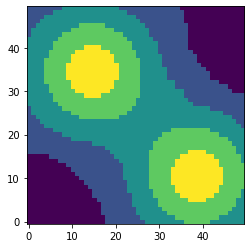

In [14]:
steps = 1000

test_model = Sugarscape_Model(vision_min=5,metabolism_max=1)
# test_model.run_model(steps)
test_model.show_grid_distribution(test_model.sugar_distribution)


# Analyze Data

In [41]:
results = test_model.datacollector.get_model_vars_dataframe()

results.head(40)

,Trader,Trade Volume,Price
0,200,242,1.003679
1,200,21,1.060899
2,200,19,1.010833
3,200,11,1.056670
4,200,5,0.996848
5,200,5,0.916365
6,200,2,0.901475
7,200,1,2.006607
8,200,0,NaN
9,200,3,1.623716


<AxesSubplot:>

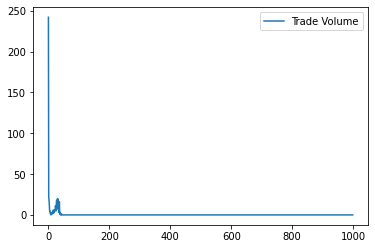

In [38]:
results.plot(y="Trade Volume", use_index=True)

<AxesSubplot:>

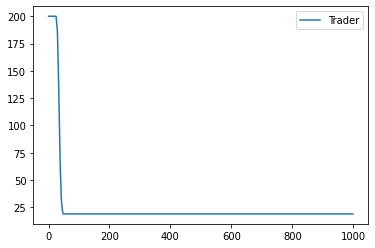

In [39]:
# plot number of agents per time step
results.plot(y="Trader", use_index=True)

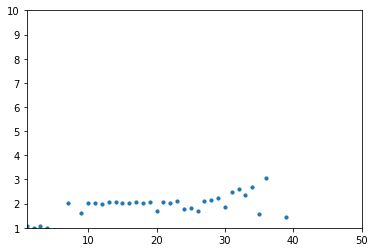

In [40]:
# plot trade price per step
y = list(results['Price'])
x = range(steps)

plt.xlim([1, 50])
plt.ylim([1, 10])
plt.scatter(x,y, s=10)